In [ ]:
from tardis_em.utils.load_data import load_image

path = '../../../../Downloads/GridA1_section1_crop_semantic.mrc'
img, px = load_image(path)

path = '../../../../Downloads/GridA1_section1_crop_semantic_auto.mrc'
img_auto, px = load_image(path)

In [ ]:
from tardis_em.dist_pytorch.utils.build_point_cloud import BuildPointCloud

post_processes = BuildPointCloud()

pc_hd, pc_ld = post_processes.build_point_cloud(
                    image=img, down_sampling=5
                )

pc_hd_auto, pc_ld_auto = post_processes.build_point_cloud(
                    image=img_auto, down_sampling=5
                )



In [ ]:
import numpy as np
pc_ld = np.hstack((np.zeros(len(pc_ld))[:, np.newaxis], pc_ld))
pc_ld_auto = np.hstack((np.zeros(len(pc_ld_auto))[:, np.newaxis], pc_ld_auto))


In [ ]:
import pandas as pd

segments = pd.DataFrame(pc_ld)
segments.to_csv(
    '../../../../Downloads/GridA1_section1_crop_semantic.csv',
    header=["IDs", "X [A]", "Y [A]", "Z [A]"],
    index=False,
    sep=",",
)

segments = pd.DataFrame(pc_ld_auto)
segments.to_csv(
    '../../../../Downloads/GridA1_section1_crop_semantic_auto.csv',
    header=["IDs", "X [A]", "Y [A]", "Z [A]"],
    index=False,
    sep=",",
)

In [ ]:
path = (
    "/Users/robertkiewisz/Desktop/test/231110_JanelTTLL11_212-800_100nM_010_no_salt.nd2"
)

extensions_points = (".csv",)

extensions_images = (".rec", ".mrc", ".tiff", ".tif", ".nd2", ".am")
path.endswith(extensions_images)

In [ ]:
import os
import numpy as np

path = "../../../tesing_data/TS_Dogic_800.mrc_16.56Apx_SpatialGraph_filter.am"
with open(path, "r") as f:
    df = next(f).split(" ")

if {"AS", "ASI"}.intersection(df):
    print(True)

In [ ]:
f.readline(-1)

In [ ]:
import torch


def get_available_devices():
    devices = ["cpu"]

    # Check if CUDA (NVIDIA GPU) is available and list all available CUDA devices
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            devices.append(f"cuda:{i}")

    # Check for MPS (Apple's Metal Performance Shaders) availability
    if torch.backends.mps.is_available():
        devices.append("mps")

    return devices

In [ ]:
get_available_devices()

In [ ]:
import numpy as np

data = np.genfromtxt(
    "../../../test/Predictions/231110_JanelTTLL11_212-800_100nM_010_no_salt_3_instances_filter.csv",
    skip_header=1,
    delimiter=",",
    dtype=np.float16,
)
unique_ids = np.unique(data[:, 0])

In [ ]:
from os.path import splitext, basename

path = "../../../test/Predictions/231110_JanelTTLL11_212-800_100nM_010_no_salt_3_instances_filter.csv"
splitext(basename(path))[0]

In [ ]:
data = data[:, 1:]
data = np.vstack((data[:, 2], data[:, 1], data[:, 0])).T
data

In [ ]:
from tardis_em.utils.load_data import load_nd2_file
import os

dirs_ = "../../../../Downloads/MTs_TIRF/"
paths = [i for i in os.listdir(dirs_) if i.endswith(".nd2")]

# nd2, _ = load_nd2_file(os.path.join(dirs_, paths[0]), )

nd2_ = []
for i in paths:
    nd2, _ = load_nd2_file(
        os.path.join(dirs_, i),
    )
    nd2_.append(nd2)

In [ ]:
paths[7]

In [ ]:
for i in nd2_:
    print(i.shape)

In [ ]:
import matplotlib.pyplot as plt

i = 7
print(nd2_[i].shape)
plt.imshow(nd2_[i][0, 0, 0, ...], cmap="gray")

In [ ]:
import numpy as np

np.mean(nd2_[i][0, 0, 0, ...]) / np.std(nd2_[i][0, 0, 0, ...])

In [ ]:
from tardis_em.utils.visualize_pc import show_image_list

show_image_list([i for i in nd2])

In [ ]:
from tardis_em.utils.load_data import load_image
import matplotlib.pyplot as plt


img, px = load_image("../../../ht_example/10805/g3_MMM1_TS1_dose-filt.rec")
print(px)
plt.figure(dpi=300)
# plt.axis('off')
plt.hist(img.flatten())

In [38]:
import scipy
import numpy as np
from tardis_em.utils.normalization import RescaleNormalize, MeanStdNormalize
norm = RescaleNormalize((.1, 99.9))
mstd = MeanStdNormalize()

init_frame = mstd(norm(img[1, 0, 0, ...]))
curr_frame = mstd(norm(img[1, 0, 1, ...]))

# init_frame = init_frame - np.mean(init_frame)
# curr_frame = curr_frame - np.mean(curr_frame)

# calculate the correlation image; note the flipping of onw of the images
shift = scipy.signal.fftconvolve(init_frame, curr_frame[::-1,::-1], mode='full')
np.unravel_index(np.argmax(shift), shift.shape)

(np.int64(931), np.int64(1508))

In [34]:
(924//2, 1506//2)

(462, 753)

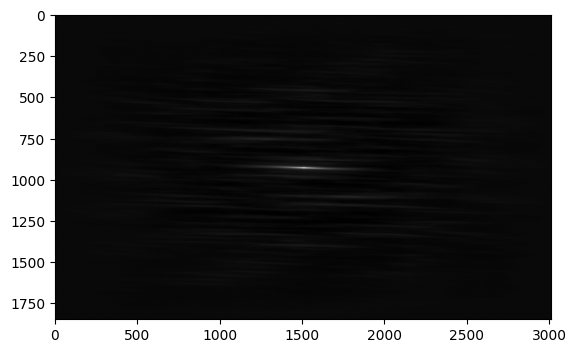

In [39]:
import matplotlib.pyplot as plt
plt.imshow(shift, cmap="gray")

In [3]:
from tardis_em.utils.load_data import load_image
from tardis_em.utils.visualize_pc import show_image_list

img, px = load_image(
    "../../../test_tirf/movie/2024-10-14_TTLL11_212-800_100nM_005.nd2")


In [4]:
from tardis_em.analysis.geometry_metrics import total_length, thicken_line_coordinates, pixel_intensity
from scipy.interpolate import splprep, splev


def co_localize_tirf(image: np.ndarray, filaments: np.ndarray, channel_in: int, thickness: int, name: str):
    """
    - Get all channels, and dim_ as a channel to which we colocalizing
    - get thicness from bt1 and bt2 as the bigger one
    - for each MT
        - extract MT track on all channels
        - Compute co-localized signal between all channels
        - append resoults
    Args:
        image (np.ndarray): image data of shape (C, T, H, W) or (C, H, W)
    """
    channels = [i for i in range(image.shape[0]) if i != channel_in]
    if image.ndim == 4:
        C, T, H, W = image.shape
    else:
        C, H, W = image.shape
        T = None

    colocalized_data_mean = []
    for i in np.unique(filaments[:, 0]):
        tck, u = splprep(data.T, s=0)

        data_fine = np.linspace(0, 1, 2 * int(total_length(data)))
        data_fine = np.array(splev(data_fine, tck)).T

        pixel_coords = np.rint(data_fine).astype(int)
        pixel_coords = np.unique(pixel_coords, axis=0)
        pixel_coords = thicken_line_coordinates(pixel_coords, thickness)

        if T is None:
            intensity_ch_in = pixel_intensity(pixel_coords, image[channel_in, ...])
            intensity_ch_out = []
            for i in channels:
                intensity_ch_out.append(pixel_intensity(pixel_coords, image))


SyntaxError: incomplete input (896692307.py, line 25)

In [2]:
from napari_tardis_em.viewers.utils import frames_phase_correlation

for i in range(img.shape[1]):
    img[1, i, ...] = frames_phase_correlation(img[1, i, ...])

(np.int64(1), np.int64(-1))
(np.int64(2), np.int64(0))
(np.int64(2), np.int64(0))
(np.int64(3), np.int64(1))
(np.int64(4), np.int64(1))
(np.int64(5), np.int64(1))
(np.int64(6), np.int64(2))
(np.int64(6), np.int64(2))
(np.int64(7), np.int64(2))
(np.int64(7), np.int64(2))
(np.int64(7), np.int64(3))
(np.int64(8), np.int64(2))
(np.int64(8), np.int64(3))
(np.int64(8), np.int64(3))
(np.int64(8), np.int64(3))
(np.int64(8), np.int64(3))
(np.int64(8), np.int64(3))
(np.int64(8), np.int64(3))
(np.int64(8), np.int64(3))
(np.int64(7), np.int64(3))
(np.int64(7), np.int64(3))
(np.int64(7), np.int64(3))
(np.int64(7), np.int64(3))
(np.int64(6), np.int64(3))
(np.int64(6), np.int64(3))
(np.int64(6), np.int64(3))
(np.int64(5), np.int64(2))
(np.int64(5), np.int64(2))
(np.int64(4), np.int64(2))
(np.int64(4), np.int64(2))
(np.int64(1), np.int64(-1))
(np.int64(2), np.int64(0))
(np.int64(2), np.int64(0))
(np.int64(3), np.int64(1))
(np.int64(3), np.int64(1))
(np.int64(4), np.int64(1))
(np.int64(5), np.int64(2))

In [3]:
from napari_tardis_em.viewers.utils import frames_phase_correlation

frames_cor = frames_phase_correlation(frames)

In [4]:
import tifffile.tifffile as tif
import numpy as np
# tif.imwrite('../../../test_tirf/movie/frames.tif', frames)
tif.imwrite('../../../test_tirf/movie/frames_cor.tif', img)

(array([4.2092303e+07, 6.7799100e+05, 3.2327500e+05, 4.2301000e+04,
        1.3230000e+03, 3.3300000e+02, 1.5000000e+02, 1.0700000e+02,
        4.3000000e+01, 3.8000000e+01]),
 array([   89.,  1210.,  2331.,  3452.,  4573.,  5694.,  6815.,  7936.,
         9057., 10178., 11299.]),
 <BarContainer object of 10 artists>)

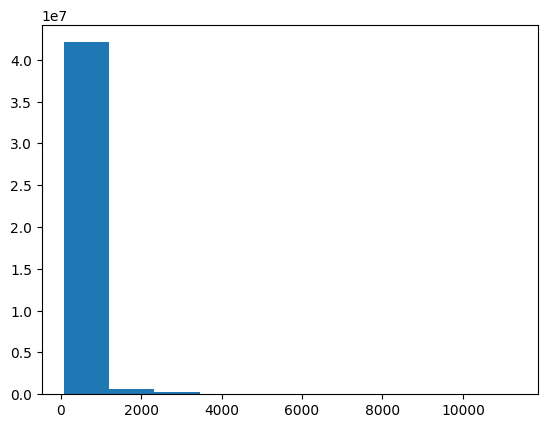

In [5]:
import matplotlib.pyplot as plt

plt.hist(frames.flatten())

(array([4.1898966e+07, 9.3737200e+05, 2.7600200e+05, 2.3259000e+04,
        1.0450000e+03, 4.9400000e+02, 3.0100000e+02, 2.1700000e+02,
        1.4300000e+02, 6.5000000e+01]),
 array([ -307.77474976,  1013.39904785,  2334.57299805,  3655.74682617,
         4976.92041016,  6298.09423828,  7619.26806641,  8940.44238281,
        10261.61621094, 11582.79003906, 12903.96386719]),
 <BarContainer object of 10 artists>)

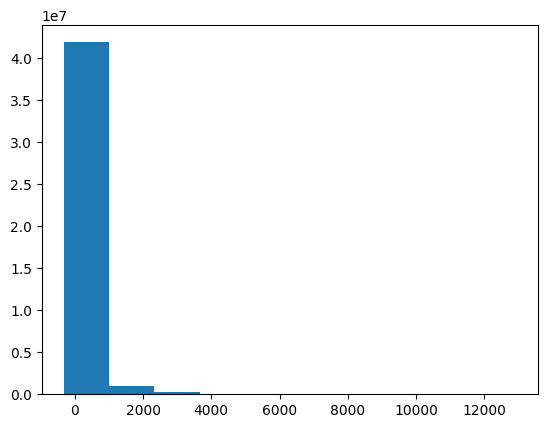

In [6]:
plt.hist(frames_cor.flatten())

In [14]:
strings='0.5'
strings = strings.replace(',', '.') if ',' in strings else strings
float(strings)


0.5

In [2]:
from tardis_em.analysis.spatial_graph_utils import FilterSpatialGraph
import numpy as np

segments = np.genfromtxt('../../../test_tirf/movie/Predictions/2024-10-14_TTLL11_212-800_100nM_005_0_instances.csv', delimiter=',')[1:, ...]

filter_splines = FilterSpatialGraph(
                        connect_seg_if_closer_then=25,
                        cylinder_radius=12,
                        filter_short_segments=10,
                    )
segments_filter = filter_splines(segments=segments, px=None)


In [6]:
from tardis_em.utils.visualize_pc import VisualizePointCloud
VisualizePointCloud(segments_filter, True)

NameError: name 'o3d' is not defined